In [1]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import mapclassify as mc

import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sklearn

In [2]:
boros = gpd.read_file("MCLP_data/inner_London.shp")

boros = boros.to_crs("epsg:27700")

inner_rd = gpd.read_file("MCLP_data/Inner_road.shp")

inner_rd = inner_rd.to_crs("epsg:27700")

In [3]:
current_buffer200 = gpd.read_file("MCLP_data/current_buffer200.shp")

current_buffer200 = current_buffer200.to_crs("epsg:27700")

pot_loc_new_dock = gpd.read_file("MCLP_data/potential_dock_jul31.shp")

pot_loc_new_dock = pot_loc_new_dock.to_crs("epsg:27700")

lsoa_cen_with_demand = gpd.read_file("MCLP_data/LOSA_cen_with_pop&bei.shp")

lsoa_cen_with_demand = lsoa_cen_with_demand.to_crs("epsg:27700")

In [4]:
pot_loc_new_dock_buffer200 = gpd.read_file("MCLP_data/potential_dock_aug5_2_buffer200.shp")

pot_loc_new_dock_buffer200 = pot_loc_new_dock_buffer200.to_crs("epsg:27700")

In [5]:
BEI_dem_cov = gpd.read_file("MCLP_data/BEI_dem_cov.shp")

BEI_dem_cov = BEI_dem_cov.to_crs("epsg:27700")

In [6]:
lsoa_cen_covered = gpd.read_file("MCLP_data/lsoa_cen_covered.shp")

lsoa_cen_covered = lsoa_cen_covered.to_crs("epsg:27700")

lsoa_cen_UNcovered = gpd.read_file("MCLP_data/lsoa_cen_UNcovered.shp")

lsoa_cen_UNcovered = lsoa_cen_UNcovered.to_crs("epsg:27700")

In [7]:
len(lsoa_cen_UNcovered)

953

In [8]:
to_drop = ['field_1', 'id', 'name', 'lat', 'long', 'nbBikes','nbEmptyDoc','nbDocks','Count']
lsoa_cen_UNcovered_final = lsoa_cen_UNcovered.drop(columns=to_drop)
lsoa_cen_UNcovered_final.head(2)

LSOA11CD        LSOA11NM   BEI_ind   overlap%  uncovered%  \
0  E01003995  Southwark 014B  4.618706  38.482761   61.517239   
1  E01003997  Southwark 017E  1.167221   0.000000  100.000000   

                 status var1 var2 bi_var  Pop_lsoa  \
0  Slight undersupplied    2    B     2B    1384.0   
1              Balanced    1    A     1A    1219.0   

                        geometry  
0  POINT (531882.979 178424.867)  
1  POINT (532171.057 177975.732)

In [9]:
lsoa_cen_UNcovered_final['demand_coe'] = 0

In [10]:
#give undersupply lsoa a coefficient of 10, slightly undersupply a 5, balanced a 1, all oversupply a 0.1
#to integrate equity into population

for row in range(0,953):
    if lsoa_cen_UNcovered_final['bi_var'][row] == '3A':
        lsoa_cen_UNcovered_final['demand_coe'][row] = 3 * lsoa_cen_UNcovered_final['Pop_lsoa'][row]
    elif lsoa_cen_UNcovered_final['bi_var'][row] == '2A' or lsoa_cen_UNcovered_final['bi_var'][row] == '3B':
        lsoa_cen_UNcovered_final['demand_coe'][row] = 2 * lsoa_cen_UNcovered_final['Pop_lsoa'][row]
    elif lsoa_cen_UNcovered_final['bi_var'][row] == '1A' or lsoa_cen_UNcovered_final['bi_var'][row] == '2B' or lsoa_cen_UNcovered_final['bi_var'][row] == '3C':
        lsoa_cen_UNcovered_final['demand_coe'][row] = 0.1 * lsoa_cen_UNcovered_final['Pop_lsoa'][row]
    else:
        lsoa_cen_UNcovered_final['demand_coe'][row] = 0.01 * lsoa_cen_UNcovered_final['Pop_lsoa'][row]

C:\Users\qq675\AppData\Local\Temp\ipykernel_22396\4197708129.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lsoa_cen_UNcovered_final['demand_coe'][row] = 0.1 * lsoa_cen_UNcovered_final['Pop_lsoa'][row]


In [58]:
lsoa_cen_UNcovered_final['bi_var'][(lsoa_cen_UNcovered_final['bi_var']=='3B')].count()

12

In [11]:
import warnings
warnings.filterwarnings('ignore')
import geopandas
import matplotlib.pyplot as plt
import pulp
from allagash import Coverage, Problem
%matplotlib inline

In [12]:
pot_loc_new_dock_buffer200

LSOA11CD          LSOA11NM    BEI_ind pot_id  \
0     E01033603  Westminster 009I   8.260204      0   
1     E01033603  Westminster 009I   8.260204      1   
2     E01033603  Westminster 009I   8.260204      2   
3     E01033605  Westminster 009K  12.395661      3   
4     E01033606  Westminster 014F  10.020210      4   
...         ...               ...        ...    ...   
9432  E01003150      Lambeth 032F   0.000000   9432   
9433  E01003150      Lambeth 032F   0.000000   9433   
9434  E01003150      Lambeth 032F   0.000000   9434   
9435  E01003150      Lambeth 032F   0.000000   9435   
9436  E01003150      Lambeth 032F   0.000000   9436   

                                               geometry  
0     POLYGON ((527578.903 181948.132, 527566.668 18...  
1     POLYGON ((527484.585 182002.495, 527472.349 18...  
2     POLYGON ((527536.238 182020.061, 527524.002 18...  
3     POLYGON ((527092.636 182296.441, 527080.400 18...  
4     POLYGON ((525418.328 181433.917, 525406.092 18...  
...                                                 ...  
9432  POLYGON ((530674.375 171052.075, 530662.139 17...  
9433  POLYGON ((530585.210 171194.172, 530572.974 17...  
9434  POLYGON ((530381.622 171208.815, 530369.386 17...  
9435  POLYGON ((530299.003 171329.345, 530286.767 17...  
9436  POLYGON ((530653.239 171172.484, 530641.003 17...  

[9437 rows x 5 columns]

In [13]:
new_coverage = Coverage.from_geodataframes(lsoa_cen_UNcovered_final, 
                                           pot_loc_new_dock_buffer200, 
                                           "LSOA11CD", "pot_id", 
                                           demand_col="demand_coe", demand_name="demand")

### MCLP Loop

# The for-loop below takes around 8 hours to complete.

In [41]:
lsoa_unsup_num = len(lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '2A']) + len(lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3A']) + len(lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3B'])

In [45]:
covered_new = pd.DataFrame(columns=['new_pop_num','new_pop_per','new_lsoa_num', 'new_lsoa_per','2A_num','3A_num','3B_num'],index=range(1,100))

In [46]:
import timeit


In [47]:
#careful!
start = timeit.default_timer()

count = 1

while count <= 100:
    print(f'now {count} new docks')
    new_problem = Problem.mclp(new_coverage, max_supply={new_coverage: count})
    new_problem.solve(pulp.GLPK())
    selected_locations = pot_loc_new_dock_buffer200.query(f"pot_id in ({[f'{i}' for i in new_problem.selected_supply(new_coverage)]})")
    selected_locations['area_id'] = selected_locations.index
    new_dock = gpd.sjoin(selected_locations, lsoa_cen_UNcovered_final, how="left", op="contains")
    sum_now = new_dock.groupby(["area_id"]).sum()
    to_drop = ['BEI_ind_left', 'index_right', 'overlap%', 'uncovered%',
           'BEI_ind_right']
    sum_now = sum_now.drop(columns=to_drop)
    selected_locations_final = pd.merge(selected_locations, sum_now, how = 'left', left_on = 'area_id', right_on = 'area_id')    
    final_new_dock = selected_locations_final.sort_values(['LSOA11CD', 'demand_coe'], ascending=[True, False]).drop_duplicates(['LSOA11CD']).reset_index(drop=True)

    #calculating new coverage
    lsoa_cen_new_cover = gpd.sjoin(lsoa_cen_UNcovered, final_new_dock, how="right", op="intersects")

    
    lsoa_2A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '2A']
    lsoa_3A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3A']
    lsoa_3B_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3B']
    lsoa_unsup_new_cover = len(lsoa_3B_new) + len(lsoa_3A_new) + len(lsoa_2A_new)
    print(f'Percentage of undersupplied lsoas being newly covered: {(lsoa_unsup_new_cover / lsoa_unsup_num  * 100):0.2f}%')
    
    frames = [lsoa_2A_new,lsoa_3A_new, lsoa_3B_new]
    new_cover = pd.concat(frames)
    print(f'Percentage of new population being covered: {(new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100):0.2f}%')
    
    covered_new["new_pop_num"][count] = new_cover["Pop_lsoa_left"].sum()
    covered_new["new_pop_per"][count] = new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100
    covered_new["new_lsoa_num"][count] = lsoa_unsup_new_cover
    covered_new["new_lsoa_per"][count] = lsoa_unsup_new_cover / lsoa_unsup_num  * 100
    covered_new['2A_num'][count] = len(lsoa_2A_new)
    covered_new['3A_num'][count] = len(lsoa_3A_new)
    covered_new['3B_num'][count] = len(lsoa_3B_new)
    count = count+1
    
    


#Your statements here

stop = timeit.default_timer()

print('Time: ', stop - start)

now 1 new docks
Percentage of undersupplied lsoas being newly covered: 3.20%
Percentage of new population being covered: 3.84%
now 2 new docks
Percentage of undersupplied lsoas being newly covered: 5.60%
Percentage of new population being covered: 7.01%
now 3 new docks
Percentage of undersupplied lsoas being newly covered: 8.80%
Percentage of new population being covered: 9.89%
now 4 new docks
Percentage of undersupplied lsoas being newly covered: 11.20%
Percentage of new population being covered: 12.16%
now 5 new docks
Percentage of undersupplied lsoas being newly covered: 13.60%
Percentage of new population being covered: 14.31%
now 6 new docks
Percentage of undersupplied lsoas being newly covered: 16.00%
Percentage of new population being covered: 16.58%
now 7 new docks
Percentage of undersupplied lsoas being newly covered: 17.60%
Percentage of new population being covered: 18.20%
now 8 new docks
Percentage of undersupplied lsoas being newly covered: 19.20%
Percentage of new populat

Percentage of undersupplied lsoas being newly covered: 82.40%
Percentage of new population being covered: 85.25%
now 66 new docks
Percentage of undersupplied lsoas being newly covered: 83.20%
Percentage of new population being covered: 85.98%
now 67 new docks
Percentage of undersupplied lsoas being newly covered: 84.00%
Percentage of new population being covered: 86.72%
now 68 new docks
Percentage of undersupplied lsoas being newly covered: 84.80%
Percentage of new population being covered: 87.46%
now 69 new docks
Percentage of undersupplied lsoas being newly covered: 85.60%
Percentage of new population being covered: 88.17%
now 70 new docks
Percentage of undersupplied lsoas being newly covered: 86.40%
Percentage of new population being covered: 88.95%
now 71 new docks
Percentage of undersupplied lsoas being newly covered: 87.20%
Percentage of new population being covered: 89.65%
now 72 new docks
Percentage of undersupplied lsoas being newly covered: 88.00%
Percentage of new population

In [48]:
covered_new

new_pop_num new_pop_per new_lsoa_num new_lsoa_per 2A_num 3A_num 3B_num
1       8212.0    3.836809            4          3.2      1      3      0
2      15005.0    7.010634            7          5.6      2      5      0
3      21177.0    9.894315           11          8.8      3      8      0
4      26028.0   12.160798           14         11.2      3     11      0
5      30630.0   14.310944           17         13.6      3     13      1
..         ...         ...          ...          ...    ...    ...    ...
95    214032.0       100.0          125        100.0     67     46     12
96    214032.0       100.0          125        100.0     67     46     12
97    214032.0       100.0          125        100.0     67     46     12
98    214032.0       100.0          125        100.0     67     46     12
99    214032.0       100.0          125        100.0     67     46     12

[99 rows x 7 columns]

Find the n-th new dock installation which increase the coverage to 100% 

In [147]:
covered_new[covered_new.new_lsoa_per == 100].iloc[0]

new_pop_num     214032.0
new_pop_per        100.0
new_lsoa_num         125
new_lsoa_per       100.0
2A_num                67
3A_num                46
3B_num                12
Name: 87, dtype: object

Find the n-th new dock installation which increase the coverage to 75% 

In [153]:
covered_new[covered_new.new_lsoa_per >=75].iloc[0]

new_pop_num      167953.0
new_pop_per     78.470976
new_lsoa_num           94
new_lsoa_per         75.2
2A_num                 46
3A_num                 44
3B_num                  4
Name: 56, dtype: object

Find the n-th new dock installation which increase the coverage to 50% 

In [152]:
covered_new[covered_new.new_lsoa_per >=50].iloc[0]

new_pop_num      113184.0
new_pop_per     52.881812
new_lsoa_num           63
new_lsoa_per         50.4
2A_num                 30
3A_num                 32
3B_num                  1
Name: 28, dtype: object

In [154]:
covered_new[covered_new.new_lsoa_per >=25].iloc[0]

new_pop_num       58764.0
new_pop_per     27.455708
new_lsoa_num           33
new_lsoa_per         26.4
2A_num                 10
3A_num                 22
3B_num                  1
Name: 12, dtype: object

In [49]:
covered_new_final = covered_new

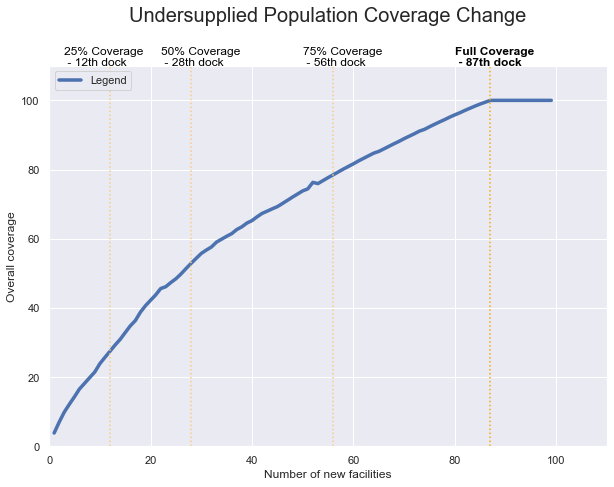

In [427]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.set(style="darkgrid")


sns.lineplot(ax=ax,data=covered_new_final["new_pop_per"],linewidth=3.5,legend=True ).set_title(
    "Undersupplied Population Coverage Change", y=1.1, size=20)

ax.set_ylim(0,110)
ax.set_xlim(0,110)
ax.legend(["Facility Coverage"])


plt.axvline(87, color='orange',linestyle=':')
plt.axvline(56, color='#FCC981',linestyle=':')
plt.axvline(28, color='#FCC981',linestyle=':')
plt.axvline(12, color='#FCC981',linestyle=':')

plt.text(80, 110, "Full Coverage \n - 87th dock", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(50, 110, "75% Coverage \n - 56th dock", horizontalalignment='left', size='medium', color='black', weight='regular')
plt.text(22, 110, "50% Coverage \n - 28th dock", horizontalalignment='left', size='medium', color='black', weight='regular')
plt.text(3, 110, "25% Coverage \n - 12th dock", horizontalalignment='left', size='medium', color='black', weight='regular')

plt.scatter(157, 100, marker='*', color='black', s=100)
ax.set(xlabel='Number of new facilities', ylabel='Overall coverage')
plt.legend(['Legend'], loc='upper left')


f.savefig("figures/fig_7_MCLP_pop_cov_change", dpi=500)

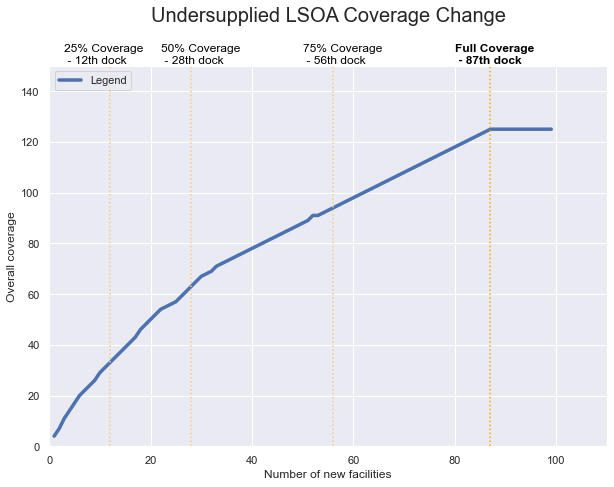

In [431]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.set(style="darkgrid")


sns.lineplot(ax=ax,data=covered_new_final["new_lsoa_num"],linewidth=3.5,legend=True ).set_title(
    "Undersupplied LSOA Coverage Change", y=1.1, size=20)

ax.set_ylim(0,150)
ax.set_xlim(0,110)
ax.legend(["Facility Coverage"])


plt.axvline(87, color='orange',linestyle=':')
plt.axvline(56, color='#FCC981',linestyle=':')
plt.axvline(28, color='#FCC981',linestyle=':')
plt.axvline(12, color='#FCC981',linestyle=':')

plt.text(80, 151, "Full Coverage \n - 87th dock", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(50, 151, "75% Coverage \n - 56th dock", horizontalalignment='left', size='medium', color='black', weight='regular')
plt.text(22, 151, "50% Coverage \n - 28th dock", horizontalalignment='left', size='medium', color='black', weight='regular')
plt.text(3, 151, "25% Coverage \n - 12th dock", horizontalalignment='left', size='medium', color='black', weight='regular')

plt.scatter(157, 100, marker='*', color='black', s=100)
ax.set(xlabel='Number of new facilities', ylabel='Overall coverage')
plt.legend(['Legend'], loc='upper left')


f.savefig("figures/fig_8_MCLP_lsoa_cov_change", dpi=500)

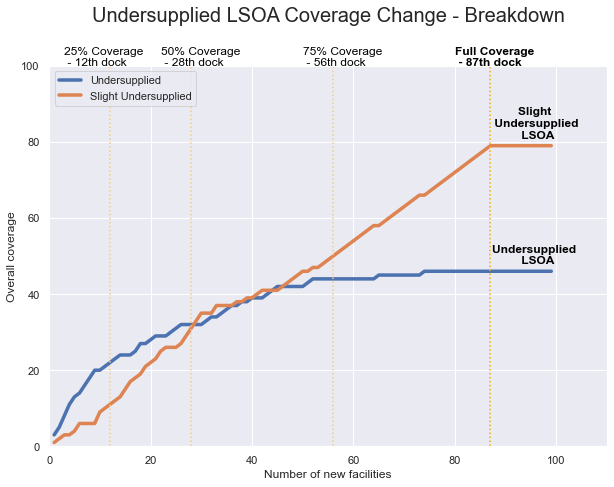

In [435]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.set(style="darkgrid")


sns.lineplot(ax=ax,data=covered_new_final["3A_num"],linewidth=3.5,legend=True )
sns.lineplot(ax=ax,data=covered_new_final["3B_num"]+covered_new_final["2A_num"],linewidth=3.5,legend=True ).set_title(
    "Undersupplied LSOA Coverage Change - Breakdown", y=1.1, size=20)

ax.set_ylim(0,100)
ax.set_xlim(0,110)
ax.legend(["Facility Coverage"])


plt.axvline(87, color='orange',linestyle=':')
plt.axvline(56, color='#FCC981',linestyle=':')
plt.axvline(28, color='#FCC981',linestyle=':')
plt.axvline(12, color='#FCC981',linestyle=':')

plt.text(80, 100, "Full Coverage \n - 87th dock", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(50, 100, "75% Coverage \n - 56th dock", horizontalalignment='left', size='medium', color='black', weight='regular')
plt.text(22, 100, "50% Coverage \n - 28th dock", horizontalalignment='left', size='medium', color='black', weight='regular')
plt.text(3, 100, "25% Coverage \n - 12th dock", horizontalalignment='left', size='medium', color='black', weight='regular')


plt.text(96, 81, "Slight \n Undersupplied \n LSOA", horizontalalignment='center', size='medium', color='black', weight='semibold')
plt.text(96, 48, "Undersupplied \n LSOA", horizontalalignment='center', size='medium', color='black', weight='semibold')


plt.scatter(157, 100, marker='*', color='black', s=100)
ax.set(xlabel='Number of new facilities', ylabel='Overall coverage')
plt.legend(['Undersupplied','Slight Undersupplied'], loc='upper left')

f.savefig("figures/fig_9_MCLP_lsoa_2line_cov_change", dpi=500)

# 87 new Docks (100% population coverage)

In [235]:
new_problem = Problem.mclp(new_coverage, max_supply={new_coverage: 87})

In [236]:
new_problem.solve(pulp.GLPK());

<AxesSubplot:>

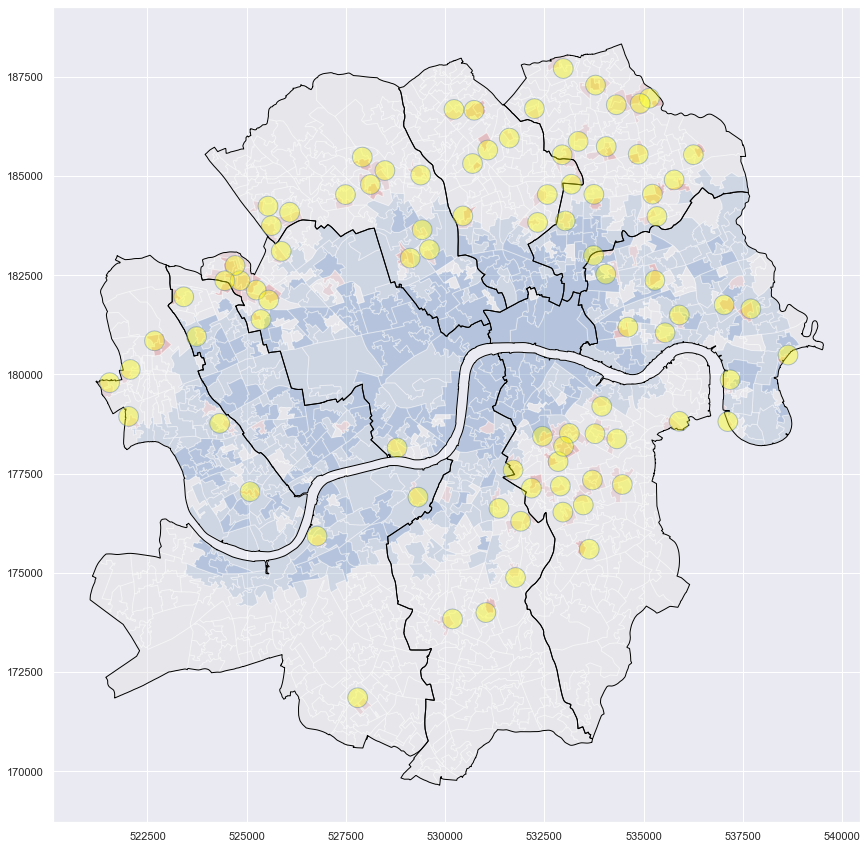

In [237]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')


biv_Palette2 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}
# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.4)



selected_locations = pot_loc_new_dock_buffer200.query(f"pot_id in ({[f'{i}' for i in new_problem.selected_supply(new_coverage)]})")

boros.plot(ax=ax, facecolor='none',edgecolor='black')
selected_locations.plot(ax=ax, color='yellow', alpha=0.4, edgecolor='b') 


In [238]:
selected_locations['area_id'] = selected_locations.index

In [239]:
new_dock = gpd.sjoin(selected_locations, lsoa_cen_UNcovered_final, how="left", op="contains")

In [240]:
sum_now = new_dock.groupby(["area_id"]).sum()

In [241]:
to_drop = ['BEI_ind_left', 'index_right','BEI_ind_right', 'overlap%', 'uncovered%']

sum_now = sum_now.drop(columns=to_drop)
sum_now.head(2)

Pop_lsoa  demand_coe
area_id                      
22         3016.0      6032.0
26         4409.0      7710.3

In [242]:
selected_locations_final = pd.merge(selected_locations, sum_now, how = 'left', left_on = 'area_id', right_on = 'area_id')

In [243]:
final_new_dock = selected_locations_final.sort_values(['LSOA11CD', 'demand_coe'], ascending=[True, False]).drop_duplicates(['LSOA11CD']).reset_index(drop=True)


In [244]:
len(final_new_dock)

87

In [245]:
lsoa_cen_new_cover = gpd.sjoin(lsoa_cen_UNcovered, final_new_dock, how="right", op="intersects")


In [246]:
lsoa_2A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '2A']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '2A'])

67

In [247]:
lsoa_3A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3A']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3A'])

46

In [248]:
lsoa_3B_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3B']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3B'])

12

In [249]:
lsoa_unsup_new_cover = len(lsoa_3B_new) + len(lsoa_3A_new) + len(lsoa_2A_new)

In [250]:
lsoa_unsup_new_cover

125

In [251]:
frames = [lsoa_2A_new,lsoa_3A_new, lsoa_3B_new]
new_cover = pd.concat(frames)

In [252]:
lsoa_2A_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '2A']
lsoa_3A_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3A']
lsoa_3B_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3B']

In [253]:
frames_unsup = [lsoa_2A_unsup,lsoa_3A_unsup, lsoa_3B_unsup]
unsup_uncover = pd.concat(frames_unsup)

In [254]:
unsup_uncover["Pop_lsoa"].sum()

214032.0

In [255]:
new_cover["Pop_lsoa_left"].sum()

214032.0

In [256]:
print(f'{(new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100):0.2f}%')

pop_cov_change = new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100

100.00%


In [257]:
pop_cov_change

100.0

In [258]:
lsoa_unsup_new_cover

125

In [259]:
lsoa_unsup_new_cover / 125  * 100

100.0

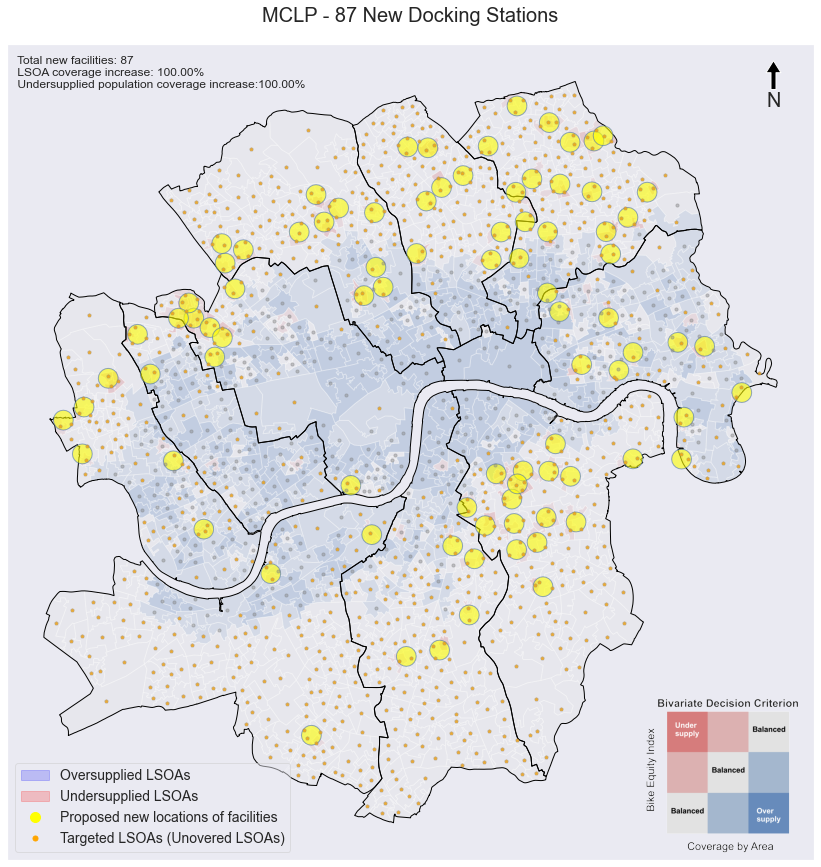

In [260]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

#selected_locations = pot_loc_new_dock_buffer200.query(f"LSOA11CD in ({[f'{i}' for i in new_problem.selected_supply(new_coverage)]})")
#drop duplicas
#unique = selected_locations.drop_duplicates(subset = ["LSOA11CD"])
#--------------------------------------------------------------------------
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "MCLP - 87 New Docking Stations", y=1.02, size=20
);


#--------------------------------------------------------------------------

biv_Palette2 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}
# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.3)

boros.plot(ax=ax, facecolor='none',edgecolor='black')
#--------------------------------------------------------------------------


#All potential locations
#kc_s2.plot(ax=ax, color='grey', alpha=0.3)    

#borough road
#inner_rd.plot(ax=ax, color='lightgrey',alpha=0.5,zorder=1)

#Current facilities
#current_buffer200.plot(ax=ax, color='green', alpha=0.2, edgecolor='b').set_title("Potential Locations for New Facilities - Westminster", size=24)  

#The new facilities produced
final_new_dock.plot(ax=ax, color='yellow', alpha=0.6, edgecolor='b') 

#All covered and uncovered
lsoa_cen_with_demand.plot(ax=ax, color='grey', markersize = 10,alpha=0.4,
          label='Covered LSOAs')  

#Uncovered Centroid
lsoa_cen_UNcovered.plot(ax=ax, color='orange', markersize = 10, alpha=0.5, marker='*',
           label='Uncovered LSOAs')  


#--------------------------------------------------------------------------



blue_patch = mpatches.Patch(color='blue',alpha=0.2, label='Oversupplied LSOAs')
red_patch = mpatches.Patch(color='red',alpha=0.2, label='Undersupplied LSOAs')
ye_patch = mpatches.Patch(color='yellow',alpha=0.6, label='Proposed new locations of facilities')
yellow_dot = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Proposed new locations of facilities')
orange_dot = mlines.Line2D([], [], color='orange', marker='o', linestyle='None',
                          markersize=5, label='Targeted LSOAs (Unovered LSOAs)')


plt.legend(handles=[blue_patch,red_patch,yellow_dot,orange_dot],loc=[0.01,0.01], prop={'size': 14}, framealpha=0.5)

#leg = ax.legend(loc=[0.08,0.155], prop={'size': 15});
#--------------------------------------------------------------------------


plt.figtext(x=0.145, y=0.84, s= f" Total new facilities: {len(selected_locations)} \n LSOA coverage increase: {(lsoa_unsup_new_cover / lsoa_unsup_num  * 100):0.2f}% \n Undersupplied population coverage increase:{(pop_cov_change):0.2f}%", size=12);


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


im = plt.imread('figures/fig_2_Bivaraite_Legend.png')

newax = fig.add_axes([0.73,0.13,0.15,0.15], anchor='SE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.show()
fig.savefig("figures/MCLP_87_100%", dpi=500)

# 56 new Docks (75% population coverage)

In [155]:
new_problem = Problem.mclp(new_coverage, max_supply={new_coverage: 56})

In [156]:
new_problem.solve(pulp.GLPK());

<AxesSubplot:>

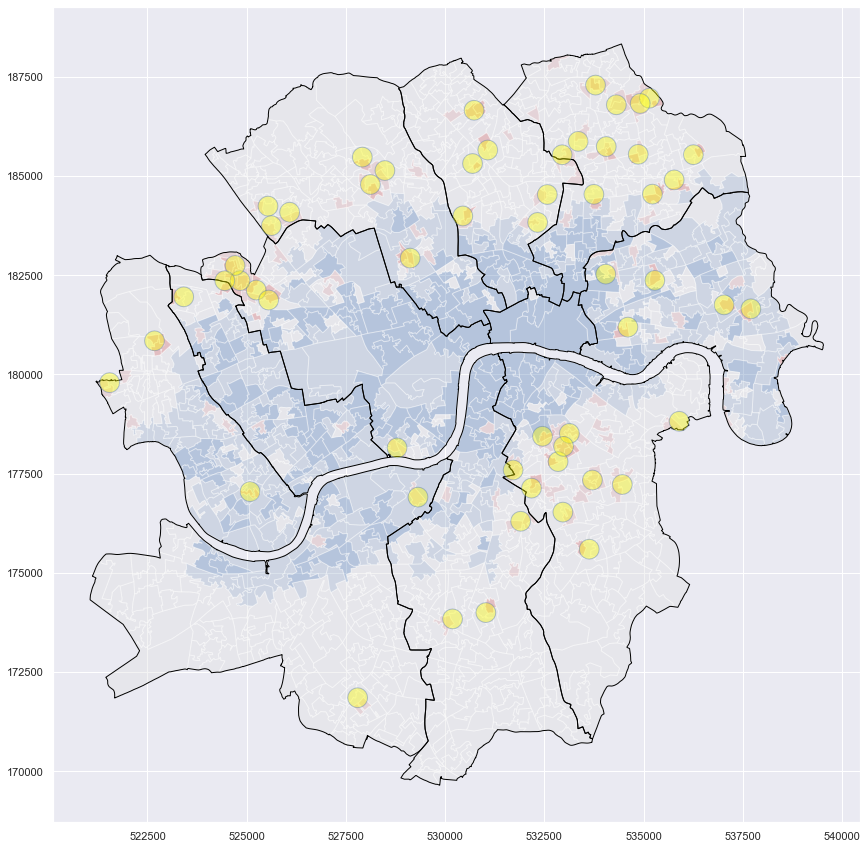

In [157]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')


biv_Palette2 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}
# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.4)



selected_locations = pot_loc_new_dock_buffer200.query(f"pot_id in ({[f'{i}' for i in new_problem.selected_supply(new_coverage)]})")

boros.plot(ax=ax, facecolor='none',edgecolor='black')
selected_locations.plot(ax=ax, color='yellow', alpha=0.4, edgecolor='b') 


In [158]:
selected_locations['area_id'] = selected_locations.index

In [159]:
new_dock = gpd.sjoin(selected_locations, lsoa_cen_UNcovered_final, how="left", op="contains")

In [160]:
sum_now = new_dock.groupby(["area_id"]).sum()

In [161]:
to_drop = ['BEI_ind_left', 'index_right','BEI_ind_right', 'overlap%', 'uncovered%']

sum_now = sum_now.drop(columns=to_drop)
sum_now.head(2)

Pop_lsoa  demand_coe
area_id                      
22         3016.0      6032.0
26         4409.0      7710.3

In [162]:
selected_locations_final = pd.merge(selected_locations, sum_now, how = 'left', left_on = 'area_id', right_on = 'area_id')

In [163]:
final_new_dock = selected_locations_final.sort_values(['LSOA11CD', 'demand_coe'], ascending=[True, False]).drop_duplicates(['LSOA11CD']).reset_index(drop=True)


In [164]:
len(final_new_dock)

56

In [165]:
lsoa_cen_new_cover = gpd.sjoin(lsoa_cen_UNcovered, final_new_dock, how="right", op="intersects")


In [166]:
lsoa_2A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '2A']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '2A'])

46

In [167]:
lsoa_3A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3A']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3A'])

44

In [168]:
lsoa_3B_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3B']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3B'])

4

In [169]:
lsoa_unsup_new_cover = len(lsoa_3B_new) + len(lsoa_3A_new) + len(lsoa_2A_new)

In [170]:
lsoa_unsup_new_cover

94

In [171]:
frames = [lsoa_2A_new,lsoa_3A_new, lsoa_3B_new]
new_cover = pd.concat(frames)

In [172]:
lsoa_2A_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '2A']
lsoa_3A_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3A']
lsoa_3B_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3B']

In [173]:
frames_unsup = [lsoa_2A_unsup,lsoa_3A_unsup, lsoa_3B_unsup]
unsup_uncover = pd.concat(frames_unsup)

In [174]:
unsup_uncover["Pop_lsoa"].sum()

214032.0

In [175]:
new_cover["Pop_lsoa_left"].sum()

167953.0

In [176]:
print(f'{(new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100):0.2f}%')

pop_cov_change = new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100

78.47%


In [177]:
pop_cov_change

78.47097630260895

In [178]:
lsoa_unsup_new_cover

94

In [179]:
lsoa_unsup_new_cover / 125  * 100

75.2

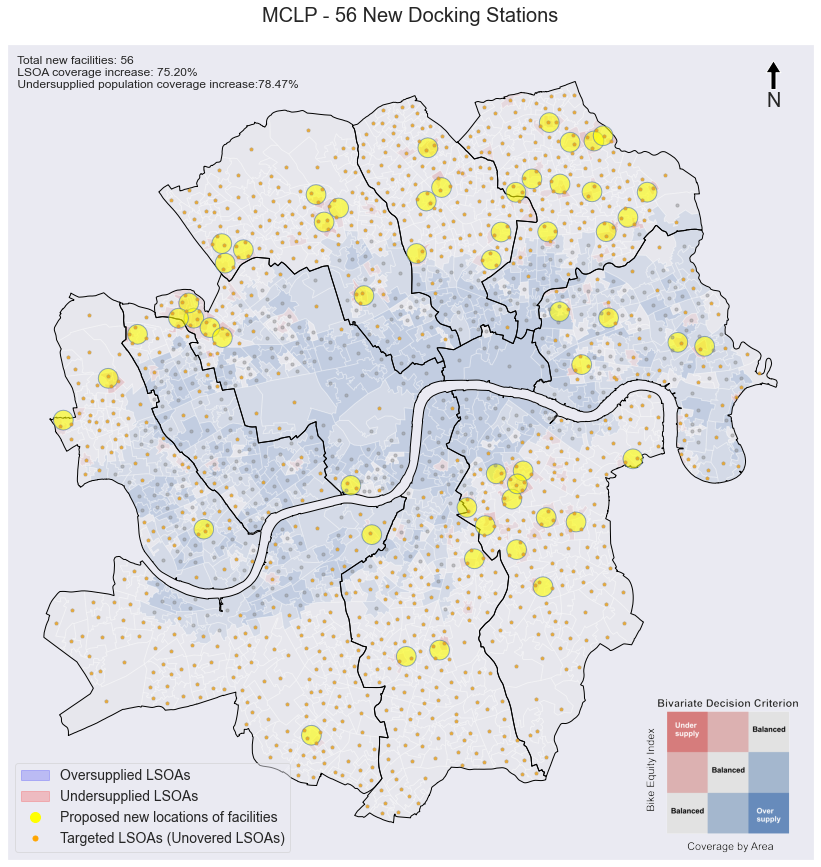

In [182]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

#selected_locations = pot_loc_new_dock_buffer200.query(f"LSOA11CD in ({[f'{i}' for i in new_problem.selected_supply(new_coverage)]})")
#drop duplicas
#unique = selected_locations.drop_duplicates(subset = ["LSOA11CD"])
#--------------------------------------------------------------------------
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "MCLP - 56 New Docking Stations", y=1.02, size=20
);


#--------------------------------------------------------------------------

biv_Palette2 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}
# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.3)

boros.plot(ax=ax, facecolor='none',edgecolor='black')
#--------------------------------------------------------------------------


#All potential locations
#kc_s2.plot(ax=ax, color='grey', alpha=0.3)    

#borough road
#inner_rd.plot(ax=ax, color='lightgrey',alpha=0.5,zorder=1)

#Current facilities
#current_buffer200.plot(ax=ax, color='green', alpha=0.2, edgecolor='b').set_title("Potential Locations for New Facilities - Westminster", size=24)  

#The new facilities produced
final_new_dock.plot(ax=ax, color='yellow', alpha=0.6, edgecolor='b') 

#All covered and uncovered
lsoa_cen_with_demand.plot(ax=ax, color='grey', markersize = 10,alpha=0.4,
          label='Covered LSOAs')  

#Uncovered Centroid
lsoa_cen_UNcovered.plot(ax=ax, color='orange', markersize = 10, alpha=0.5, marker='*',
           label='Uncovered LSOAs')  


#--------------------------------------------------------------------------



blue_patch = mpatches.Patch(color='blue',alpha=0.2, label='Oversupplied LSOAs')
red_patch = mpatches.Patch(color='red',alpha=0.2, label='Undersupplied LSOAs')
ye_patch = mpatches.Patch(color='yellow',alpha=0.6, label='Proposed new locations of facilities')
yellow_dot = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Proposed new locations of facilities')
orange_dot = mlines.Line2D([], [], color='orange', marker='o', linestyle='None',
                          markersize=5, label='Targeted LSOAs (Unovered LSOAs)')


plt.legend(handles=[blue_patch,red_patch,yellow_dot,orange_dot],loc=[0.01,0.01], prop={'size': 14}, framealpha=0.5)

#leg = ax.legend(loc=[0.08,0.155], prop={'size': 15});
#--------------------------------------------------------------------------


plt.figtext(x=0.145, y=0.84, s= f" Total new facilities: {len(selected_locations)} \n LSOA coverage increase: {(lsoa_unsup_new_cover / lsoa_unsup_num  * 100):0.2f}% \n Undersupplied population coverage increase:{(pop_cov_change):0.2f}%", size=12);


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


im = plt.imread('figures/fig_2_Bivaraite_Legend.png')

newax = fig.add_axes([0.73,0.13,0.15,0.15], anchor='SE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.show()
fig.savefig("figures/MCLP_56_75%", dpi=500)

# 28 new Docks (50% population coverage)

In [183]:
new_problem = Problem.mclp(new_coverage, max_supply={new_coverage: 28})

In [184]:
new_problem.solve(pulp.GLPK());

<AxesSubplot:>

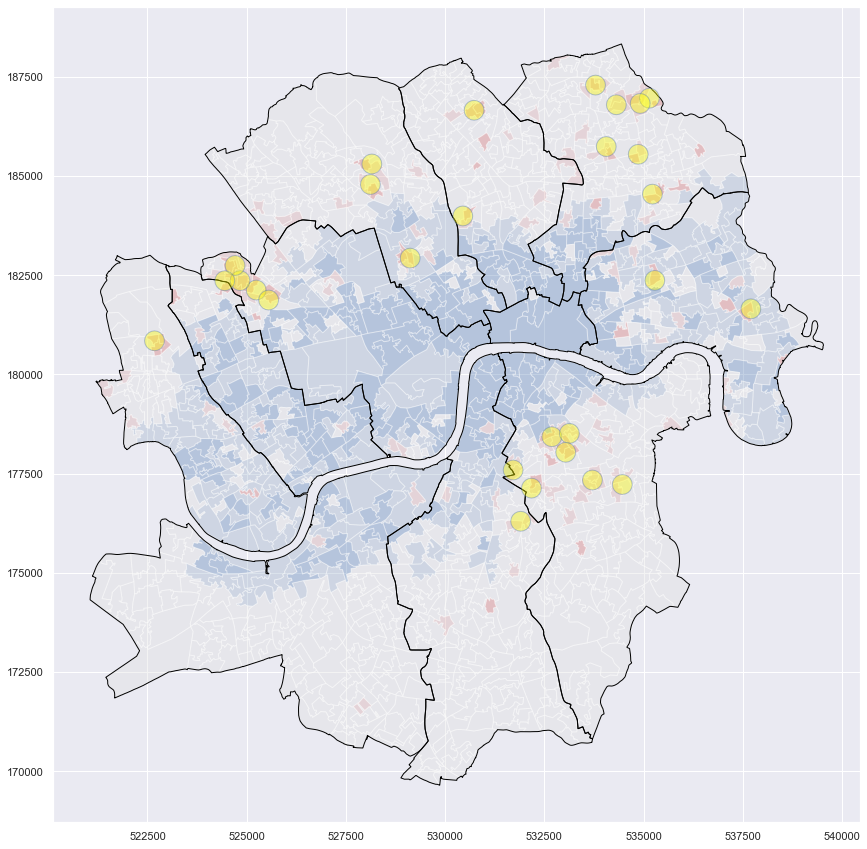

In [185]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')


biv_Palette2 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}
# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.4)



selected_locations = pot_loc_new_dock_buffer200.query(f"pot_id in ({[f'{i}' for i in new_problem.selected_supply(new_coverage)]})")

boros.plot(ax=ax, facecolor='none',edgecolor='black')
selected_locations.plot(ax=ax, color='yellow', alpha=0.4, edgecolor='b') 


In [186]:
selected_locations['area_id'] = selected_locations.index

In [187]:
new_dock = gpd.sjoin(selected_locations, lsoa_cen_UNcovered_final, how="left", op="contains")

In [188]:
sum_now = new_dock.groupby(["area_id"]).sum()

In [189]:
to_drop = ['BEI_ind_left', 'index_right','BEI_ind_right', 'overlap%', 'uncovered%']

sum_now = sum_now.drop(columns=to_drop)
sum_now.head(2)

Pop_lsoa  demand_coe
area_id                      
26         4409.0      7710.3
105        3127.0      7971.0

In [190]:
selected_locations_final = pd.merge(selected_locations, sum_now, how = 'left', left_on = 'area_id', right_on = 'area_id')

In [191]:
final_new_dock = selected_locations_final.sort_values(['LSOA11CD', 'demand_coe'], ascending=[True, False]).drop_duplicates(['LSOA11CD']).reset_index(drop=True)


In [192]:
len(final_new_dock)

28

In [193]:
lsoa_cen_new_cover = gpd.sjoin(lsoa_cen_UNcovered, final_new_dock, how="right", op="intersects")


In [194]:
lsoa_2A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '2A']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '2A'])

30

In [195]:
lsoa_3A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3A']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3A'])

32

In [196]:
lsoa_3B_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3B']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3B'])

1

In [197]:
lsoa_unsup_new_cover = len(lsoa_3B_new) + len(lsoa_3A_new) + len(lsoa_2A_new)

In [198]:
lsoa_unsup_new_cover

63

In [199]:
frames = [lsoa_2A_new,lsoa_3A_new, lsoa_3B_new]
new_cover = pd.concat(frames)

In [200]:
lsoa_2A_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '2A']
lsoa_3A_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3A']
lsoa_3B_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3B']

In [201]:
frames_unsup = [lsoa_2A_unsup,lsoa_3A_unsup, lsoa_3B_unsup]
unsup_uncover = pd.concat(frames_unsup)

In [202]:
unsup_uncover["Pop_lsoa"].sum()

214032.0

In [203]:
new_cover["Pop_lsoa_left"].sum()

113184.0

In [204]:
print(f'{(new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100):0.2f}%')

pop_cov_change = new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100

52.88%


In [205]:
pop_cov_change

52.88181206548553

In [206]:
lsoa_unsup_new_cover

63

In [207]:
lsoa_unsup_new_cover / 125  * 100

50.4

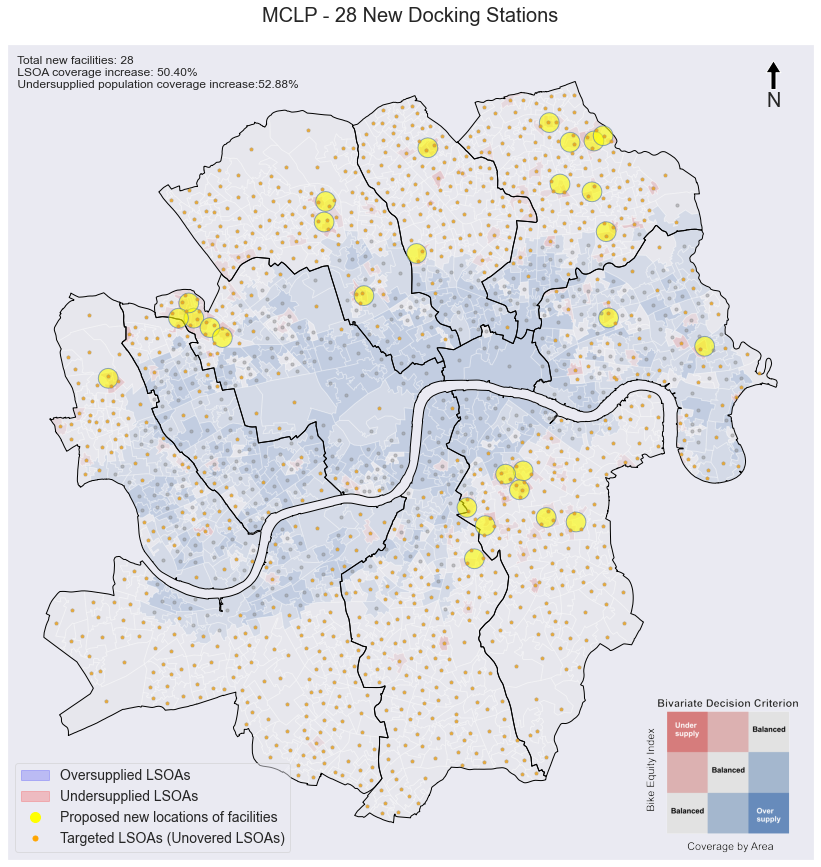

In [208]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

#selected_locations = pot_loc_new_dock_buffer200.query(f"LSOA11CD in ({[f'{i}' for i in new_problem.selected_supply(new_coverage)]})")
#drop duplicas
#unique = selected_locations.drop_duplicates(subset = ["LSOA11CD"])
#--------------------------------------------------------------------------
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "MCLP - 28 New Docking Stations", y=1.02, size=20
);


#--------------------------------------------------------------------------

biv_Palette2 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}
# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.3)

boros.plot(ax=ax, facecolor='none',edgecolor='black')
#--------------------------------------------------------------------------


#All potential locations
#kc_s2.plot(ax=ax, color='grey', alpha=0.3)    

#borough road
#inner_rd.plot(ax=ax, color='lightgrey',alpha=0.5,zorder=1)

#Current facilities
#current_buffer200.plot(ax=ax, color='green', alpha=0.2, edgecolor='b').set_title("Potential Locations for New Facilities - Westminster", size=24)  

#The new facilities produced
final_new_dock.plot(ax=ax, color='yellow', alpha=0.6, edgecolor='b') 

#All covered and uncovered
lsoa_cen_with_demand.plot(ax=ax, color='grey', markersize = 10,alpha=0.4,
          label='Covered LSOAs')  

#Uncovered Centroid
lsoa_cen_UNcovered.plot(ax=ax, color='orange', markersize = 10, alpha=0.5, marker='*',
           label='Uncovered LSOAs')  


#--------------------------------------------------------------------------



blue_patch = mpatches.Patch(color='blue',alpha=0.2, label='Oversupplied LSOAs')
red_patch = mpatches.Patch(color='red',alpha=0.2, label='Undersupplied LSOAs')
ye_patch = mpatches.Patch(color='yellow',alpha=0.6, label='Proposed new locations of facilities')
yellow_dot = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Proposed new locations of facilities')
orange_dot = mlines.Line2D([], [], color='orange', marker='o', linestyle='None',
                          markersize=5, label='Targeted LSOAs (Unovered LSOAs)')


plt.legend(handles=[blue_patch,red_patch,yellow_dot,orange_dot],loc=[0.01,0.01], prop={'size': 14}, framealpha=0.5)

#leg = ax.legend(loc=[0.08,0.155], prop={'size': 15});
#--------------------------------------------------------------------------


plt.figtext(x=0.145, y=0.84, s= f" Total new facilities: {len(selected_locations)} \n LSOA coverage increase: {(lsoa_unsup_new_cover / lsoa_unsup_num  * 100):0.2f}% \n Undersupplied population coverage increase:{(pop_cov_change):0.2f}%", size=12);


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


im = plt.imread('figures/fig_2_Bivaraite_Legend.png')

newax = fig.add_axes([0.73,0.13,0.15,0.15], anchor='SE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.show()

fig.savefig("figures/MCLP_28_50%", dpi=500)

# 12 new Docks (25% population coverage)

In [209]:
new_problem = Problem.mclp(new_coverage, max_supply={new_coverage: 12})

In [210]:
new_problem.solve(pulp.GLPK());

<AxesSubplot:>

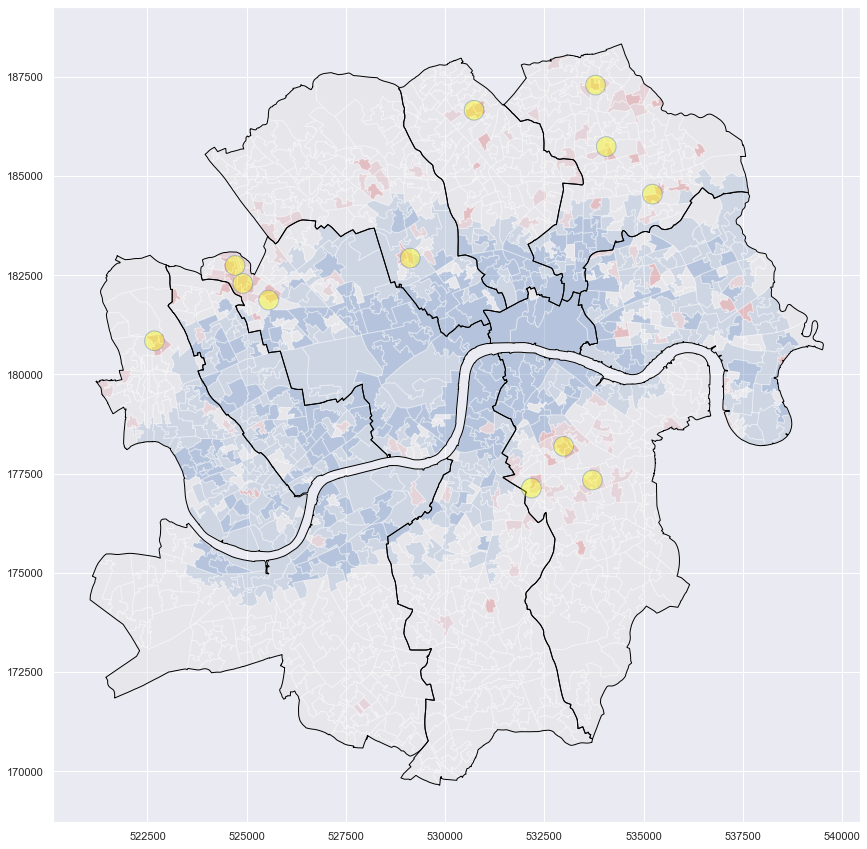

In [211]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')


biv_Palette2 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}
# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.4)



selected_locations = pot_loc_new_dock_buffer200.query(f"pot_id in ({[f'{i}' for i in new_problem.selected_supply(new_coverage)]})")

boros.plot(ax=ax, facecolor='none',edgecolor='black')
selected_locations.plot(ax=ax, color='yellow', alpha=0.4, edgecolor='b') 


In [212]:
selected_locations['area_id'] = selected_locations.index

In [213]:
new_dock = gpd.sjoin(selected_locations, lsoa_cen_UNcovered_final, how="left", op="contains")

In [214]:
sum_now = new_dock.groupby(["area_id"]).sum()

In [215]:
to_drop = ['BEI_ind_left', 'index_right','BEI_ind_right', 'overlap%', 'uncovered%']

sum_now = sum_now.drop(columns=to_drop)
sum_now.head(2)

Pop_lsoa  demand_coe
area_id                      
292        6172.0     16862.0
593        5558.0      9669.6

In [216]:
selected_locations_final = pd.merge(selected_locations, sum_now, how = 'left', left_on = 'area_id', right_on = 'area_id')

In [217]:
final_new_dock = selected_locations_final.sort_values(['LSOA11CD', 'demand_coe'], ascending=[True, False]).drop_duplicates(['LSOA11CD']).reset_index(drop=True)


In [218]:
len(final_new_dock)

12

In [219]:
lsoa_cen_new_cover = gpd.sjoin(lsoa_cen_UNcovered, final_new_dock, how="right", op="intersects")


In [220]:
lsoa_2A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '2A']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '2A'])

10

In [221]:
lsoa_3A_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3A']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3A'])

22

In [222]:
lsoa_3B_new = lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3B']
len(lsoa_cen_new_cover.loc[lsoa_cen_new_cover['bi_var'] == '3B'])

1

In [223]:
lsoa_unsup_new_cover = len(lsoa_3B_new) + len(lsoa_3A_new) + len(lsoa_2A_new)

In [224]:
lsoa_unsup_new_cover

33

In [225]:
frames = [lsoa_2A_new,lsoa_3A_new, lsoa_3B_new]
new_cover = pd.concat(frames)

In [226]:
lsoa_2A_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '2A']
lsoa_3A_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3A']
lsoa_3B_unsup = lsoa_cen_UNcovered.loc[lsoa_cen_UNcovered['bi_var'] == '3B']

In [227]:
frames_unsup = [lsoa_2A_unsup,lsoa_3A_unsup, lsoa_3B_unsup]
unsup_uncover = pd.concat(frames_unsup)

In [228]:
unsup_uncover["Pop_lsoa"].sum()

214032.0

In [229]:
new_cover["Pop_lsoa_left"].sum()

58764.0

In [230]:
print(f'{(new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100):0.2f}%')

pop_cov_change = new_cover["Pop_lsoa_left"].sum() / unsup_uncover["Pop_lsoa"].sum()*100

27.46%


In [231]:
pop_cov_change

27.455707557748376

In [232]:
lsoa_unsup_new_cover

33

In [233]:
lsoa_unsup_new_cover / 125  * 100

26.400000000000002

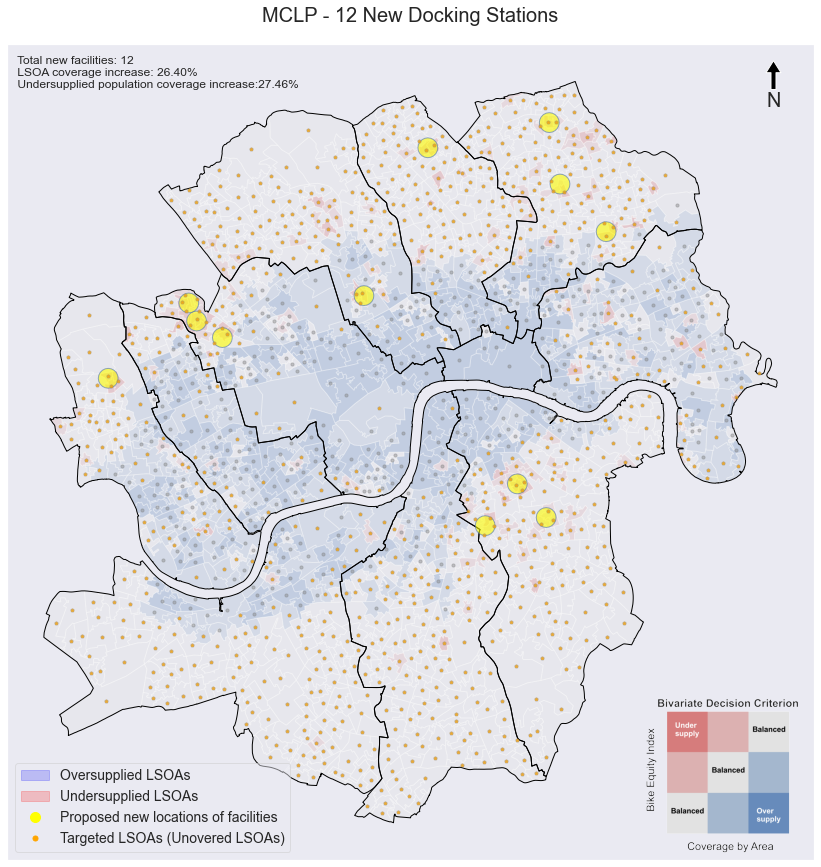

In [234]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

#selected_locations = pot_loc_new_dock_buffer200.query(f"LSOA11CD in ({[f'{i}' for i in new_problem.selected_supply(new_coverage)]})")
#drop duplicas
#unique = selected_locations.drop_duplicates(subset = ["LSOA11CD"])
#--------------------------------------------------------------------------
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "MCLP - 12 New Docking Stations", y=1.02, size=20
);


#--------------------------------------------------------------------------

biv_Palette2 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}
# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.3)

boros.plot(ax=ax, facecolor='none',edgecolor='black')
#--------------------------------------------------------------------------


#All potential locations
#kc_s2.plot(ax=ax, color='grey', alpha=0.3)    

#borough road
#inner_rd.plot(ax=ax, color='lightgrey',alpha=0.5,zorder=1)

#Current facilities
#current_buffer200.plot(ax=ax, color='green', alpha=0.2, edgecolor='b').set_title("Potential Locations for New Facilities - Westminster", size=24)  

#The new facilities produced
final_new_dock.plot(ax=ax, color='yellow', alpha=0.6, edgecolor='b') 

#All covered and uncovered
lsoa_cen_with_demand.plot(ax=ax, color='grey', markersize = 10,alpha=0.4,
          label='Covered LSOAs')  

#Uncovered Centroid
lsoa_cen_UNcovered.plot(ax=ax, color='orange', markersize = 10, alpha=0.5, marker='*',
           label='Uncovered LSOAs')  


#--------------------------------------------------------------------------



blue_patch = mpatches.Patch(color='blue',alpha=0.2, label='Oversupplied LSOAs')
red_patch = mpatches.Patch(color='red',alpha=0.2, label='Undersupplied LSOAs')
ye_patch = mpatches.Patch(color='yellow',alpha=0.6, label='Proposed new locations of facilities')
yellow_dot = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Proposed new locations of facilities')
orange_dot = mlines.Line2D([], [], color='orange', marker='o', linestyle='None',
                          markersize=5, label='Targeted LSOAs (Unovered LSOAs)')


plt.legend(handles=[blue_patch,red_patch,yellow_dot,orange_dot],loc=[0.01,0.01], prop={'size': 14}, framealpha=0.5)

#leg = ax.legend(loc=[0.08,0.155], prop={'size': 15});
#--------------------------------------------------------------------------


plt.figtext(x=0.145, y=0.84, s= f" Total new facilities: {len(selected_locations)} \n LSOA coverage increase: {(lsoa_unsup_new_cover / lsoa_unsup_num  * 100):0.2f}% \n Undersupplied population coverage increase:{(pop_cov_change):0.2f}%", size=12);


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


im = plt.imread('figures/fig_2_Bivaraite_Legend.png')

newax = fig.add_axes([0.73,0.13,0.15,0.15], anchor='SE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.show()

fig.savefig("figures/MCLP_12_25%", dpi=500)

In [282]:
df = pd.read_csv("borough_linechart.csv", index_col=0)

In [283]:
df_tr = np.transpose(df)

In [284]:
df_tr

Borough                               Camden  City of London  Hackney  \
12 New Stations\n(25% New Coverage)        1               0        3   
28 New Stations\n(50% New Coverage)        3               0        7   
56 New Stations\n(75% New Coverage)        7               0       12   
78 New Stations\n(100% New Coverage)      11               0       17   

Borough                               Hammersmith and Fulham  Islington  \
12 New Stations\n(25% New Coverage)                        1          1   
28 New Stations\n(50% New Coverage)                        1          2   
56 New Stations\n(75% New Coverage)                        3          6   
78 New Stations\n(100% New Coverage)                       6          8   

Borough                               Kensington and Chelsea  Lambeth  \
12 New Stations\n(25% New Coverage)                        0        0   
28 New Stations\n(50% New Coverage)                        0        1   
56 New Stations\n(75% New Coverage)                        1        3   
78 New Stations\n(100% New Coverage)                       2        5   

Borough                               Southwark  Tower Hamlets  Wandsworth  \
12 New Stations\n(25% New Coverage)           3              0           0   
28 New Stations\n(50% New Coverage)           7              2           0   
56 New Stations\n(75% New Coverage)          11              5           2   
78 New Stations\n(100% New Coverage)         16             11           3   

Borough                               Westminster  
12 New Stations\n(25% New Coverage)             3  
28 New Stations\n(50% New Coverage)             5  
56 New Stations\n(75% New Coverage)             6  
78 New Stations\n(100% New Coverage)            8

In [348]:
import matplotlib.ticker as ticker

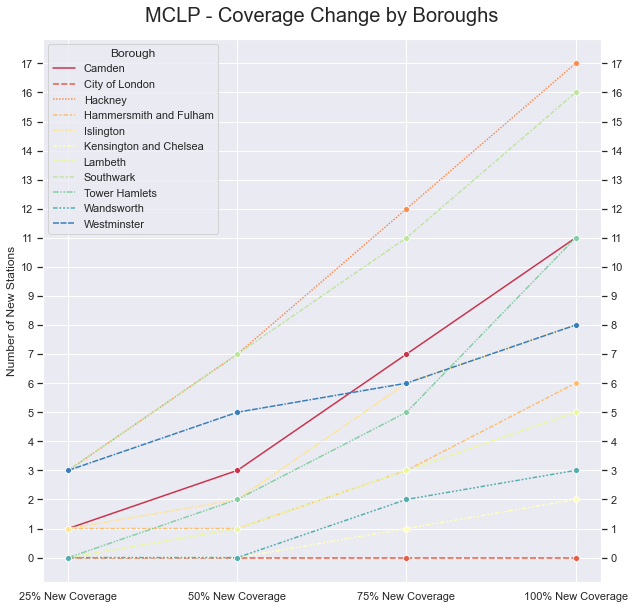

In [439]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title(
    "MCLP - Coverage Change by Boroughs", y=1.02, size=20
);


sns.lineplot(ax=ax,data=df_tr,marker='o',palette="Spectral")
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('both')
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True)
plt.xticks([0, 1, 2, 3],['25% New Coverage', '50% New Coverage', '75% New Coverage','100% New Coverage'])
plt.ylabel('Number of New Stations')


fig.savefig("figures/fig_10_MCLP_cov_change_boro", dpi=500)